In [71]:
import tensorboard
%load_ext tensorboard
%tensorboard --logdir 'logs/'
import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score
from sklearn.preprocessing import KBinsDiscretizer
# Se importan librerías para graficar.
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from keras import backend as K
import kerastuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Input
import keras.regularizers
from tensorflow.keras import optimizers
from sklearn.preprocessing import PolynomialFeatures

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 17008), started 7:46:18 ago. (Use '!kill 17008' to kill it.)

In [72]:
df = pd.read_csv('diabetes.csv')

In [73]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [74]:
healthy_people_num = (df['Outcome'] == 0).sum()
sick_people_num = (df['Outcome'] != 0).sum()
total = df.shape[0]
print("Healthy people: " + str(healthy_people_num))
print("Sick people: " + str(sick_people_num))
print("Total: " + str(total))

Healthy people: 500
Sick people: 268
Total: 768


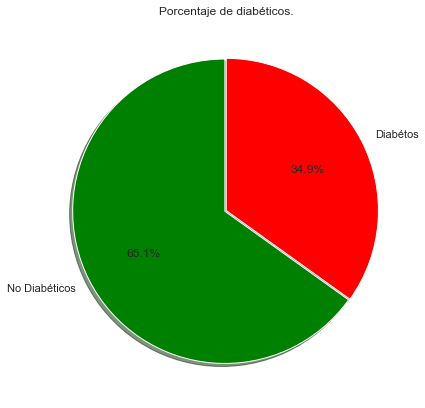

In [75]:
sns.set(style="whitegrid")
labels = ['No Diabéticos', 'Diabétos']
sizes = [healthy_people_num,sick_people_num]
colors = ["green","red"]
plt.figure(figsize=(7,7))
plt.pie(sizes, labels=labels, explode= (0.01,0) , colors=colors, autopct='%1.1f%%', shadow=True, startangle=90,)

plt.title('Porcentaje de diabéticos.')
plt.show()

In [76]:
df2 = df.copy()
df2[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df2[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

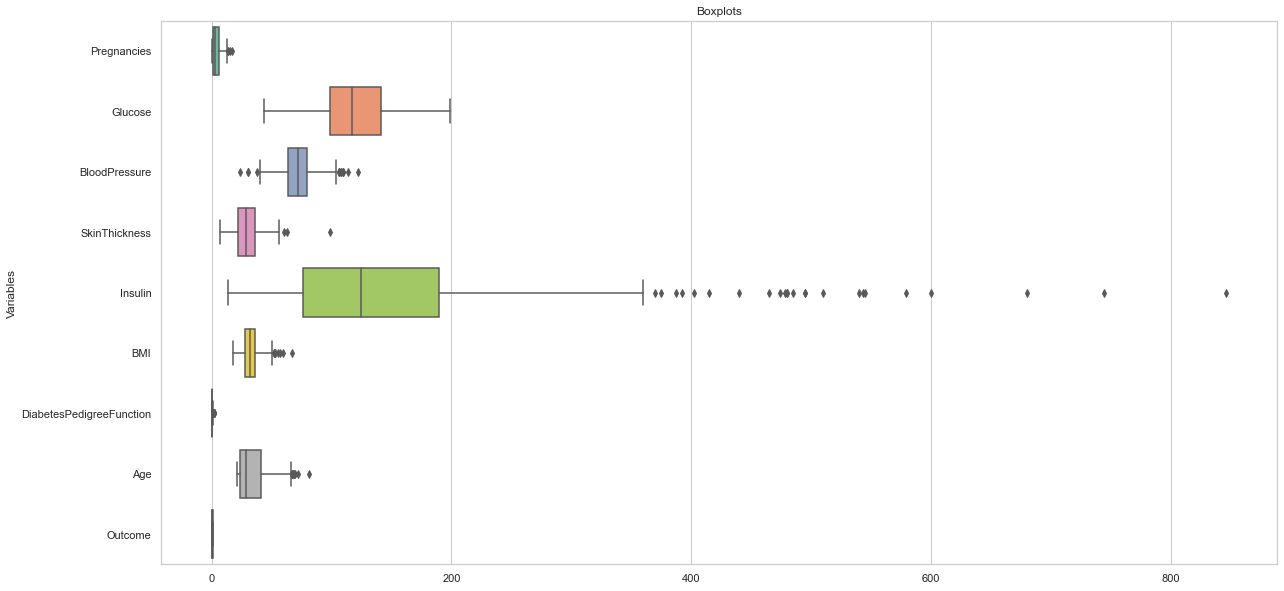

In [77]:
f, ax = plt.subplots(figsize=(20, 10))
plt.ylabel('Variables')
plt.title("Boxplots")
ax = sns.boxplot(data = df2, 
  orient = 'h', 
  palette = 'Set2')

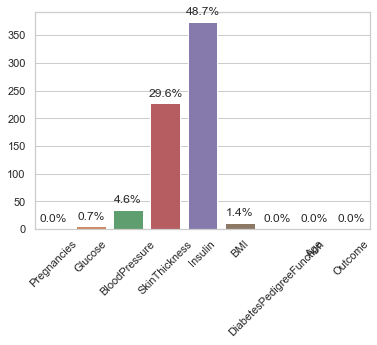

In [78]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=df2.columns, y=df2.isnull().sum())
plt.xticks(rotation=45);
for p in ax.patches:
    ax.annotate(format(100*p.get_height()/df.shape[0], '.1f') + "%", 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 10), 
                   textcoords = 'offset points')

In [79]:
correlations = df2.corr()
correlations['Outcome'].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.494650
BMI                         0.313680
Insulin                     0.303454
SkinThickness               0.259491
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
BloodPressure               0.170589
Name: Outcome, dtype: float64

In [80]:
df = df.drop(['Insulin'], axis=1)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,33.6,0.627,50,1
1,1,85,66,29,26.6,0.351,31,0
2,8,183,64,0,23.3,0.672,32,1
3,1,89,66,23,28.1,0.167,21,0
4,0,137,40,35,43.1,2.288,33,1


In [81]:
msk = np.random.rand(len(df)) < 0.9
train_df = df[msk]
test_df = df[~msk]

In [82]:
def specificity(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())


def negative_predictive_value(y_true, y_pred):
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return tn / (tn + fn + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    sens_keras = true_positives / (possible_positives + K.epsilon())
    return sens_keras

def positive_predictive_value(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    ppv_keras = true_positives / (predicted_positives + K.epsilon())
    return ppv_keras

In [83]:
def plot_loss(history):
    # Plot the training loss.
    plt.plot(history.history['loss'], 'r-')

    # Plot the validation loss.
    plt.plot(history.history['val_loss'], 'b-')

    # X-axis label.
    plt.xlabel('Epochs')

    # Y-axis label.
    plt.ylabel('Cost')

    # Graph legend.
    plt.legend(["Training loss", "Validation loss"])

    # Graph title.
    plt.title('Loss Graph')

    plt.show()

In [84]:
class DiabetesPredictor:
    def __init__(self, dataframe, name, replaceOutliers=False, deleteRowsWithOutliers=False, replaceNulls=False,deleteRowsWithNulls=False, nullColumns=[], outliersColumns=[], columnsToRemove=[], polyFeatDeg = -1, binsDiscretizer = -1):
        """DiabetesPredictor

    This is a class contains the most part of the methods needed for the diabetes predictor,
    first get the data of the csv file and then perform some methods to clean the data insid
    and allows you to choose if it has to replace outliers or not and replace nulls values or not.


    Attributes:
        replace_outliers: Use the string "replace_outliers" if you want to do that on your model with the median value
        replace_nulls: Use the string "replace_nulls" to replace all nulls in your model with the median value
        delete_row_with_outliers: Use the string "delete_row_with_outliers" to replace all the rows that contains outliers
    """
        self.df = dataframe.copy()
        self.name = name

        nullCols = nullColumns.copy()
        outlierCols = outliersColumns.copy()

        self.__remove_columns__(columnsToRemove)
        
        nullCols = [n for n in nullColumns if n not in columnsToRemove]
        outlierCols = [out for out in outliersColumns if out[0] not in columnsToRemove]

        if (replaceNulls or deleteRowsWithNulls):
            self.df[nullCols] = self.df[nullCols].replace(0,np.NaN)

        if(replaceOutliers):
            self.__replace_outliers__(outlierCols)
        elif(deleteRowsWithOutliers): 
            self.__delete_row_with_outliers__(outlierCols)

        if(replaceNulls):
            self.__replace_nulls__(nullCols)
        elif (deleteRowsWithNulls):
            self.__delete_row_with_nulls__(nullCols)

        self.__separate_data_and_labels__()

        if (polyFeatDeg > 0):
            poly = PolynomialFeatures(degree=polyFeatDeg)
            self.x = poly.fit_transform(self.x)

        if (binsDiscretizer > 1):
            disc = KBinsDiscretizer(n_bins=binsDiscretizer, encode='ordinal', strategy='uniform')
            self.x = disc.fit_transform(self.x)

        self.__normalize_data__()
        self.__split_train_val__()

    def __separate_data_and_labels__(self):
        df_values = self.df.values
        self.x = df_values[:,:-1]
        self.y = df_values[:, -1].reshape(self.x.shape[0], 1)

    def __normalize_data__(self):
        # Mean, columnar axis.
        x_mean = np.mean(self.x, axis=0, keepdims=True)
        # Std. Deviation, columnar axis.
        x_std = np.std(self.x, axis=0, keepdims=True)
        # Normalizing.
        self.x = (self.x - x_mean)/x_std
    
    def __replace_outliers__(self, cols):
        #Para cada columna (excepto para el Outcome) se reemplazan los outliers por su mediana.
        if(cols == []):
            for col in self.df.columns:
                cols.append([col, np.Infinity, 0])
        for col in cols:
            Upper_val, Lower_val, med = self.__get_outliers_limits__(col)
            #Reemplazo.
            for i in self.df[col[0]]:
                if i > Upper_val or i < Lower_val:
                    self.df[col[0]] = self.df[col[0]].replace(i, med)

    def __get_outliers_limits__(self, col, want_med = True):
        #Cálculo de parámetros para obtener los outliers.
        q1 = self.df[col[0]].quantile(0.25)
        q3 = self.df[col[0]].quantile(0.75)
        iqr = q3-q1
        #Límites de los valores tipicos.
        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr

        Lower_val = min(Lower_tail, col[1])
        Upper_val = max(Upper_tail, col[2])
        #Cálculo de la mediana.
        med = np.median(self.df[col[0]])
        if(want_med == True):
            return Upper_val, Lower_val, med
        else:
            return Upper_val, Lower_val

    def __replace_nulls__(self, cols):
        columns = cols
        median=self.df[columns].median()
        self.df[columns]=self.df[columns].replace(np.NaN,median)

    def __remove_columns__(self, cols):
        self.df = self.df.drop(cols, axis=1)
    
    def __split_train_val__(self):
        self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(self.x, self.y, test_size=0.1, random_state=5)

    def __model_builder__(self,hp):
        model = Sequential()
        initializer = tf.keras.initializers.GlorotNormal(seed=7)
        model.add(Dense(1, kernel_initializer=initializer, activation='sigmoid', input_shape=(self.x.shape[1],)))

        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        hp_momentum = hp.Choice('momentum',values=[0.9, 0.99, 0.999])
        hp_learning_rate = hp.Float('learning_rate', 1e-5, 1.0, sampling='log', default=1e-3)
        

        model.compile(optimizer=optimizers.SGD(momentum=hp_momentum, learning_rate=hp_learning_rate, ),
                        loss=keras.losses.BinaryCrossentropy(),
                        metrics=[tf.keras.metrics.AUC()])

        return model

    def __find_best_hyperparams__(self):
        log_dir = "logs/" + datetime.datetime.now().strftime("%m%d-%H%M")
        hist_callback = tf.keras.callbacks.TensorBoard(
            log_dir=log_dir,
            histogram_freq=1,
            embeddings_freq=1,
            write_graph=True,
            update_freq='batch')
        self.tuner = kt.Hyperband(self.__model_builder__,
                     kt.Objective("val_loss", direction="min"),
                     max_epochs=20,
                     factor=3,
                     executions_per_trial=3,
                     project_name=self.name,
                     directory='saved_models'
                     )
        self.tuner.search(self.x_train, self.y_train, epochs=100, validation_split=0.2, use_multiprocessing=True)
        self.best_hps=self.tuner.get_best_hyperparameters(num_trials=2)[0]

    def get_best_hyperparams(self):
        return 'Learning Rate: ' + str(self.best_hps.get('learning_rate')) + '   --   Momentum: ' + str(self.best_hps.get('momentum'))

    def train_model(self):
        self.__find_best_hyperparams__()
        model = self.tuner.hypermodel.build(self.best_hps)
        history = model.fit(self.x_train, self.y_train, epochs=100, validation_split=0.2, verbose=0)
        plot_loss(history)
        val_acc_per_epoch = history.history['val_loss']
        best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
        print('Best epoch: %d' % (best_epoch,))
        #plot_loss(history)
        self.hypermodel = self.tuner.hypermodel.build(self.best_hps)
        # Retrain the model
        self.hypermodel.fit(self.x_train, self.y_train, epochs=best_epoch, validation_split=0.2)

    def validate_model(self):
        self.predictions = self.hypermodel(self.x_val)
        self.fpr_keras, self.tpr_keras, self.thresholds_keras = roc_curve(self.y_val, self.predictions)
        self.auc_keras = auc(self.fpr_keras, self.tpr_keras)
        return self.auc_keras

    def plot_roc(self):
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(self.fpr_keras, self.tpr_keras, label='Keras (area = {:.3f})'.format(self.auc_keras))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()

    def get_metrics(self):
        print('AUC ' + str(self.auc_keras))
        rounded_preds = np.rint(self.predictions)
        print('Specificity: ' + str(specificity(self.y_val.astype(float),  rounded_preds.astype(float))))
        print('Sensitivity: ' + str(sensitivity(self.y_val.astype(float),  rounded_preds.astype(float))))
        print('Positive Predictive Value: ' + str(positive_predictive_value(self.y_val.astype(float), rounded_preds.astype(float))))
        print('Negative Predictive Value: ' + str(negative_predictive_value(self.y_val.astype(float), rounded_preds.astype(float))))
    
    def __delete_row_with_outliers__(self, cols):
        #Para cada columna (excepto para el Outcome) se buscan los outliers para borrar la fila
        if(cols == []):
            for col in self.df.columns:
                cols.append([col, np.Infinity, 0])
        for col in cols:
            Upper_val, Lower_val, med = self.__get_outliers_limits__(col)
            self.df = self.df[(Lower_val < self.df[col[0]]) & (self.df[col[0]] < Upper_val)]

    def __delete_row_with_nulls__(self, cols):
        for col in cols:
            self.df = self.df[pd.notnull(self.df[col])]
        

In [55]:
predictor = DiabetesPredictor(train_df,'predictor')

Trial 30 Complete [00h 00m 13s]
val_loss: 1.2079917192459106

Best val_loss So Far: 0.5347925821940104
Total elapsed time: 00h 03m 52s
INFO:tensorflow:Oracle triggered exit


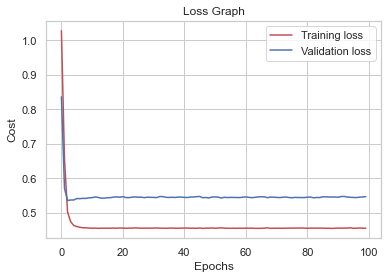

Best epoch: 3
Epoch 1/3
16/16 [==============================] - 2s 29ms/step - loss: 1.0248 - auc: 0.3652 - val_loss: 0.8535 - val_auc: 0.4885
Epoch 2/3
16/16 [==============================] - 0s 3ms/step - loss: 0.6634 - auc: 0.6390 - val_loss: 0.5679 - val_auc: 0.7917
Epoch 3/3
16/16 [==============================] - 0s 3ms/step - loss: 0.5048 - auc: 0.8192 - val_loss: 0.5346 - val_auc: 0.8204


In [56]:
predictor.train_model()

In [57]:
predictor.get_best_hyperparams()

'Learning Rate: 0.014037809000550322   --   Momentum: 0.9'

In [58]:
auc_pred = predictor.validate_model()
print('AUC: ' + str(auc_pred))

AUC: 0.8597883597883598


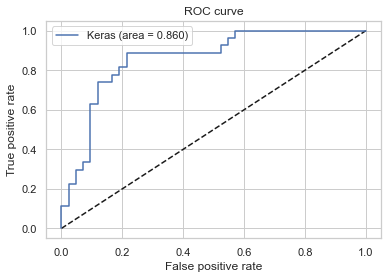

In [59]:
predictor.plot_roc()

In [60]:
predictor.get_metrics()

AUC 0.8597883597883598
Specificity: tf.Tensor(0.8809523788548753, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.629629627297668, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.772727269214876, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.7872340408782255, shape=(), dtype=float64)


## Limpiando Datos

#### Reemplazando Nulls por la mediana

Trial 30 Complete [00h 00m 11s]
val_loss: 0.5402886668841044

Best val_loss So Far: 0.5346909761428833
Total elapsed time: 00h 03m 44s
INFO:tensorflow:Oracle triggered exit


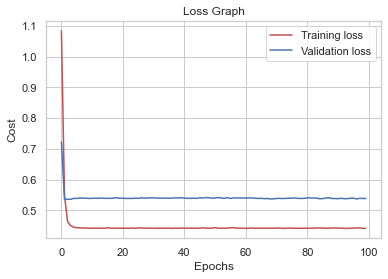

Best epoch: 4
Epoch 1/4
16/16 [==============================] - 1s 26ms/step - loss: 1.0920 - auc: 0.3465 - val_loss: 0.7245 - val_auc: 0.5959
Epoch 2/4
16/16 [==============================] - 0s 3ms/step - loss: 0.5448 - auc: 0.7795 - val_loss: 0.5372 - val_auc: 0.8137
Epoch 3/4
16/16 [==============================] - 0s 3ms/step - loss: 0.4666 - auc: 0.8485 - val_loss: 0.5363 - val_auc: 0.8140
Epoch 4/4
16/16 [==============================] - 0s 3ms/step - loss: 0.4502 - auc: 0.8544 - val_loss: 0.5368 - val_auc: 0.8144
AUC: 0.8368606701940036


In [61]:
predictorRepNulls = DiabetesPredictor(train_df,'rep_nulls_predictor' ,replaceNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'])
predictorRepNulls.train_model()
aucRepNulls = predictorRepNulls.validate_model()
print('AUC: ' + str(aucRepNulls))

In [62]:
predictorRepNulls.get_best_hyperparams()

'Learning Rate: 0.01816647519105338   --   Momentum: 0.9'

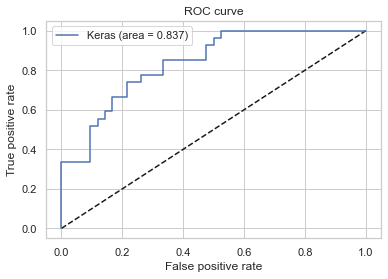

AUC 0.8368606701940036
Specificity: tf.Tensor(0.8809523788548753, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.5185185165980796, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.7368421013850416, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.73999999852, shape=(), dtype=float64)


In [63]:
predictorRepNulls.plot_roc()
predictorRepNulls.get_metrics()

#### Removiendo Nulls

Trial 30 Complete [00h 00m 14s]
val_loss: 0.4463497002919515

Best val_loss So Far: 0.42612998684247333
Total elapsed time: 00h 03m 30s
INFO:tensorflow:Oracle triggered exit


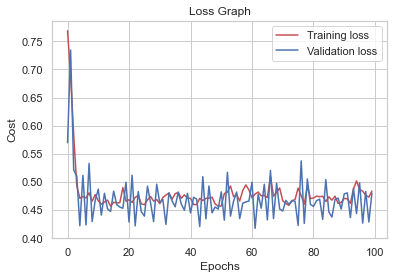

Best epoch: 62
Epoch 1/62
11/11 [==============================] - 2s 70ms/step - loss: 0.7616 - auc: 0.6978 - val_loss: 0.5748 - val_auc: 0.8924
Epoch 2/62
11/11 [==============================] - 0s 5ms/step - loss: 0.6534 - auc: 0.8286 - val_loss: 0.6710 - val_auc: 0.8346
Epoch 3/62
11/11 [==============================] - 0s 5ms/step - loss: 0.5201 - auc: 0.8250 - val_loss: 0.4847 - val_auc: 0.8833
Epoch 4/62
11/11 [==============================] - 0s 5ms/step - loss: 0.4843 - auc: 0.8285 - val_loss: 0.5145 - val_auc: 0.8458
Epoch 5/62
11/11 [==============================] - 0s 5ms/step - loss: 0.4646 - auc: 0.8377 - val_loss: 0.4369 - val_auc: 0.8948
Epoch 6/62
11/11 [==============================] - 0s 5ms/step - loss: 0.4617 - auc: 0.8428 - val_loss: 0.4854 - val_auc: 0.8738
Epoch 7/62
11/11 [==============================] - 0s 5ms/step - loss: 0.4650 - auc: 0.8309 - val_loss: 0.4450 - val_auc: 0.8933
Epoch 8/62
11/11 [==============================] - 0s 10ms/step - loss: 0

In [64]:
predictorRemNulls = DiabetesPredictor(train_df,'rem_nulls_predictor' ,deleteRowsWithNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'])
predictorRemNulls.train_model()
aucRemNulls = predictorRemNulls.validate_model()
print('AUC: ' + str(aucRemNulls))

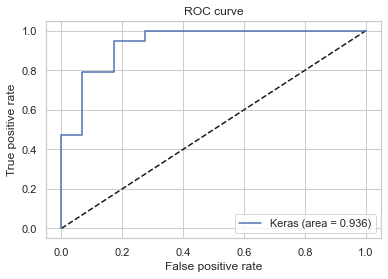

AUC 0.9364791288566243
Specificity: tf.Tensor(0.9310344795481569, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.6842105227146814, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.866666660888889, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8181818157024793, shape=(), dtype=float64)


In [65]:
predictorRemNulls.plot_roc()
predictorRemNulls.get_metrics()

#### Removiendo Outliers

Trial 30 Complete [00h 00m 11s]
val_loss: 0.9906103610992432

Best val_loss So Far: 0.5025066832701365
Total elapsed time: 00h 03m 43s
INFO:tensorflow:Oracle triggered exit


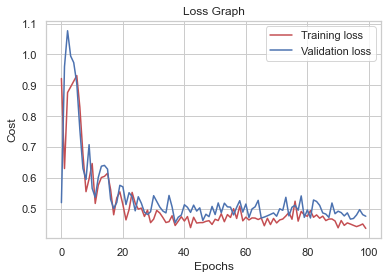

Best epoch: 38
Epoch 1/38
11/11 [==============================] - 1s 36ms/step - loss: 0.9427 - auc: 0.4598 - val_loss: 0.5378 - val_auc: 0.8323
Epoch 2/38
11/11 [==============================] - 0s 4ms/step - loss: 0.6492 - auc: 0.8363 - val_loss: 1.0172 - val_auc: 0.8117
Epoch 3/38
11/11 [==============================] - 0s 5ms/step - loss: 0.9029 - auc: 0.8293 - val_loss: 1.0896 - val_auc: 0.7986
Epoch 4/38
11/11 [==============================] - 0s 4ms/step - loss: 0.9326 - auc: 0.8238 - val_loss: 1.0266 - val_auc: 0.7996
Epoch 5/38
11/11 [==============================] - 0s 5ms/step - loss: 0.9620 - auc: 0.8099 - val_loss: 1.0511 - val_auc: 0.7534
Epoch 6/38
11/11 [==============================] - 0s 4ms/step - loss: 0.9966 - auc: 0.8099 - val_loss: 0.9684 - val_auc: 0.7669
Epoch 7/38
11/11 [==============================] - 0s 10ms/step - loss: 0.8914 - auc: 0.8190 - val_loss: 0.8037 - val_auc: 0.8168
Epoch 8/38
11/11 [==============================] - 0s 4ms/step - loss: 0

In [66]:
predictorRemOutliers = DiabetesPredictor(train_df,'rem_outliers_predictor' ,deleteRowsWithNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'], deleteRowsWithOutliers=True, outliersColumns=[['BMI', 18.5, 50],['BloodPressure',40,120],['SkinThickness', np.Infinity, 0], ['Pregnancies',np.Infinity,0]])
predictorRemOutliers.train_model()
aucRemOut = predictorRemOutliers.validate_model()
print('AUC: ' + str(aucRemOut))

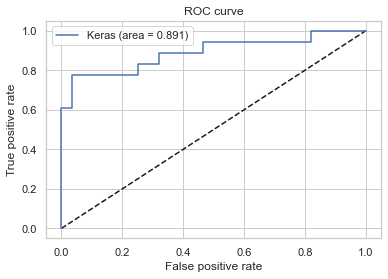

AUC 0.8908730158730158
Specificity: tf.Tensor(0.9642857108418367, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.7777777734567901, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.9333333271111112, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8709677391259105, shape=(), dtype=float64)


In [67]:
predictorRemOutliers.plot_roc()
predictorRemOutliers.get_metrics()

#### Reemplazando Outliers

Trial 30 Complete [00h 00m 09s]
val_loss: 0.4728023906548818

Best val_loss So Far: 0.4728023906548818
Total elapsed time: 00h 03m 08s
INFO:tensorflow:Oracle triggered exit


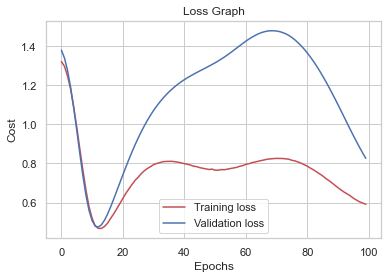

Best epoch: 13
Epoch 1/13
11/11 [==============================] - 1s 33ms/step - loss: 1.3218 - auc: 0.3125 - val_loss: 1.3811 - val_auc: 0.3313
Epoch 2/13
11/11 [==============================] - 0s 4ms/step - loss: 1.2982 - auc: 0.3154 - val_loss: 1.3403 - val_auc: 0.3375
Epoch 3/13
11/11 [==============================] - 0s 4ms/step - loss: 1.2483 - auc: 0.3242 - val_loss: 1.2761 - val_auc: 0.3470
Epoch 4/13
11/11 [==============================] - 0s 4ms/step - loss: 1.1775 - auc: 0.3376 - val_loss: 1.1903 - val_auc: 0.3574
Epoch 5/13
11/11 [==============================] - 0s 3ms/step - loss: 1.0877 - auc: 0.3589 - val_loss: 1.0878 - val_auc: 0.3746
Epoch 6/13
11/11 [==============================] - 0s 4ms/step - loss: 0.9886 - auc: 0.3894 - val_loss: 0.9730 - val_auc: 0.4058
Epoch 7/13
11/11 [==============================] - 0s 4ms/step - loss: 0.8773 - auc: 0.4425 - val_loss: 0.8541 - val_auc: 0.4667
Epoch 8/13
11/11 [==============================] - 0s 4ms/step - loss: 0.

In [68]:
predictorRepOutliers = DiabetesPredictor(train_df,'rep_outliers_predictor' ,deleteRowsWithNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'], replaceOutliers=True, outliersColumns=[['BMI', 18.5, 50],['BloodPressure',40,120], ['Pregnancies',np.Infinity,0]])
predictorRepOutliers.train_model()
aucRepOut = predictorRepOutliers.validate_model()
print('AUC: ' + str(aucRepOut))

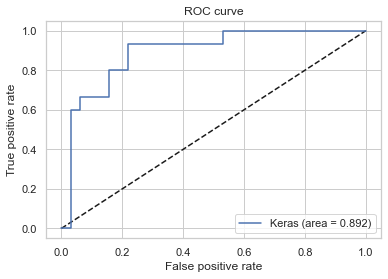

AUC 0.8916666666666667
Specificity: tf.Tensor(0.7812499975585937, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.7999999946666667, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.6315789440443214, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8928571396683673, shape=(), dtype=float64)


In [69]:
predictorRepOutliers.plot_roc()
predictorRepOutliers.get_metrics()

#### Removiendo Columnas

In [70]:
bestAuc = aucRepNulls
tryRemovingCols = ['BloodPressure', 'Age', 'DiabetesPedigreeFunction', 'Pregnancies', 'SkinThickness']
removeCols = []
removeColsAuc = []
nullCols = ['Glucose','BloodPressure','SkinThickness','BMI']

for col in tryRemovingCols:
	print(col)
	pred = DiabetesPredictor(df, col, deleteRowsWithNulls=True, nullColumns=nullCols, columnsToRemove=[col], replaceOutliers=True, outliersColumns=[['BMI', 18.5, 50],['BloodPressure',40,120], ['Pregnancies',np.Infinity,0]])
	pred.train_model()
	aucR = pred.validate_model()
	if (aucR>bestAuc):
		removeCols.append(col)
		removeColsAuc.append(aucR)



Trial 23 Complete [00h 00m 07s]
val_loss: 0.5848986109097799

Best val_loss So Far: 0.4039476811885834
Total elapsed time: 00h 02m 29s

Search: Running Trial #24

Hyperparameter    |Value             |Best Value So Far 
momentum          |0.99              |0.9               
learning_rate     |0.683             |0.67963           
tuner/epochs      |7                 |20                
tuner/initial_e...|0                 |7                 
tuner/bracket     |1                 |2                 
tuner/round       |0                 |2                 

Epoch 1/7


KeyboardInterrupt: 

In [251]:
print(removeCols)

['BloodPressure', 'Age', 'DiabetesPedigreeFunction', 'SkinThickness']


Trial 30 Complete [00h 00m 19s]
val_loss: 0.5838766892751058

Best val_loss So Far: 0.45565574367841083
Total elapsed time: 00h 07m 02s
INFO:tensorflow:Oracle triggered exit


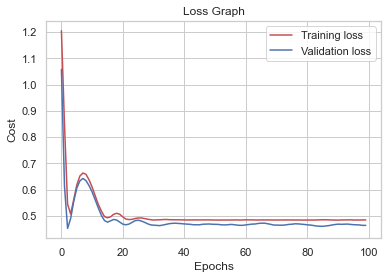

Best epoch: 3
Epoch 1/3
18/18 [==============================] - 3s 54ms/step - loss: 0.6863 - auc: 0.6750 - val_loss: 0.6350 - val_auc: 0.6730
Epoch 2/3
18/18 [==============================] - 0s 4ms/step - loss: 0.5956 - auc: 0.7384 - val_loss: 0.5301 - val_auc: 0.7807
Epoch 3/3
18/18 [==============================] - 0s 4ms/step - loss: 0.5022 - auc: 0.8161 - val_loss: 0.4746 - val_auc: 0.8415


In [254]:
finalPred = DiabetesPredictor(df,'final' ,deleteRowsWithNulls=True, nullColumns=['Glucose','BloodPressure','SkinThickness','BMI'],  columnsToRemove=removeCols, replaceOutliers=True, outliersColumns=[['BMI', 18.5, 50],['BloodPressure',40,120], ['Pregnancies',np.Infinity,0]])
finalPred.train_model()
aucFinal = finalPred.validate_model()

In [255]:
print('AUC: ' + str(aucFinal))

AUC: 0.8679245283018868


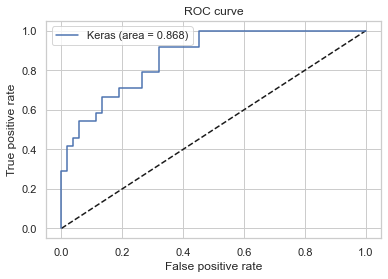

AUC 0.8679245283018868
Specificity: tf.Tensor(0.8490566021715913, shape=(), dtype=float64)
Sensitivity: tf.Tensor(0.6666666638888888, shape=(), dtype=float64)
Positive Predictive Value: tf.Tensor(0.6666666638888888, shape=(), dtype=float64)
Negative Predictive Value: tf.Tensor(0.8490566021715913, shape=(), dtype=float64)


In [256]:
finalPred.plot_roc()
finalPred.get_metrics()